### Sub-Samping of Diatom Data 

#### Criteria

* Spring and Autumn samples available
* Environment data present
* TDI available
* Sequence count > 10,000
* Sub-sample covers TDI range
* Number of sequence files to be computationally feasible giving resources

In [1]:
%matplotlib inline

#### Plot the 2016 data on a map and colour-code the TDI value for each sample site

In [2]:
import folium
import pandas as pd

In [127]:
df = pd.read_csv('2016-data.csv')

In [246]:
m = folium.Map(location=[52.904278, -2.486737],zoom_start=6)

def get_colour(x):
    if x < 25.0:
        c = '#421E69'
    elif x < 50.0:
        c = '#3F6289'
    elif x < 75.0:
        c = '#64BA7B'
    else:
        c = '#D7E14E'
    return c

for i, row in df_spr.iterrows():
    folium.CircleMarker([row.Lon, row.Lat],
                        radius=8, 
                        fill_color=get_colour(row.LM_TDI5),
                        fill=True, 
                        fill_opacity=0.6,
                        stroke=False,
                        popup='<i>{}</i>'.format(row.SPT_Name)
                       ).add_to(m)
    
m

### Create sub-sample
The strategy used is to sample across the Spring readings and then add in the corresponding Autumn readings for each selected sites.

In [130]:
df_spr = df[df['Season'] == 'Spr'].copy()
df_aut = df[df['Season'] == 'Aut'].copy()

In [229]:
df_spr['Binned'] = pd.cut(df_spr['LM_TDI5'], 5)
grouped = df_spr.groupby(df_spr['Binned'])

In [230]:
grouped.size()

Binned
(6.209, 22.03]      23
(22.03, 37.773]     51
(37.773, 53.515]    64
(53.515, 69.258]    64
(69.258, 85.0]      32
dtype: int64

In [231]:
# Total number of sequence files is 936
# Number of sequence files = n * 5 (number of bins) * 2 (corresponding Autumn files) * 2 (forward / reverse read files)
sub_selection = grouped.apply(lambda x: x.sample(n=10, replace=False))

In [233]:
temp = []
for i, row_i in sub_selection.iterrows():
    for j, row_j in df_aut.iterrows():
        if row_j['BIOSYS site ID'] == row_i['BIOSYS site ID']:
            temp.append(row_j)
sub_selection = sub_selection.append(pd.DataFrame(temp, columns=sub_selection.columns))

### Plot the sub-sample onto the map

In [247]:
for i, row in sub_selection.iterrows():
    folium.CircleMarker([row.Lon, row.Lat],
                        radius=4, 
                        fill_color='red',
                        fill=True, 
                        fill_opacity=1.0,
                        stroke=False
                       ).add_to(m)
m

### Plot original NGS TDI against LM TDI

r = 0.87


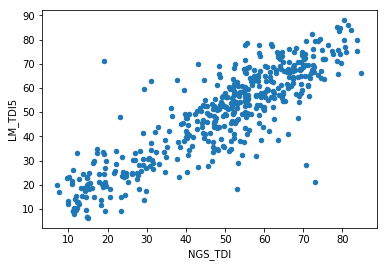

In [248]:
df.plot.scatter('NGS_TDI', 'LM_TDI5')
corr_df = df[['NGS_TDI', 'LM_TDI5']].corr(method='pearson')
corr = corr_df['LM_TDI5']['NGS_TDI']
print("r = {0:.2f}".format(corr))

### Plot sub-sample NGS TDI against LM TDI

r = 0.88


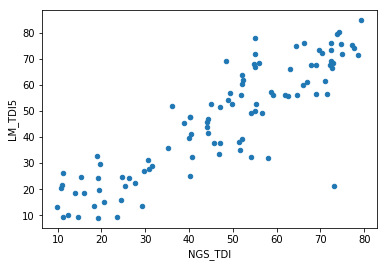

In [240]:
sub_selection.plot.scatter('NGS_TDI', 'LM_TDI5')
corr_df = sub_selection[['NGS_TDI', 'LM_TDI5']].corr(method='pearson')
corr = corr_df['LM_TDI5']['NGS_TDI']
print("r = {0:.2f}".format(corr))

### Create names of sequence files corresponding to the sub-sample

In [244]:
with open('selection-filenames.txt', 'w') as seq_files:
    for i, sample in sub_selection.iterrows():
        run_number = sample['NGS Run Number'].rstrip()
        fera_id = sample['FERAID']
        seq_files.write("/Users/graham/Box/Biodiversity/Diatom_Data/data/2016/Run_{}/raw_data/{}.R1.fastq.gz\n".format(run_number,fera_id))
        seq_files.write("/Users/graham/Box/Biodiversity/Diatom_Data/data/2016/Run_{}/raw_data/{}.R2.fastq.gz\n".format(run_number,fera_id))


### Copy sub-sampled sequence files acros to local directory

In [245]:
!for file in $(cat selection-filenames.txt) ; \
do cp ${file} selected-sequences/ ; \
done